In [5]:
# Torch-related imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, Subset

# Scikit-learn-related imports
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix, accuracy_score

# Nibabel and Scipy imports (for handling fMRI and image processing)
import nibabel as nib
import scipy.ndimage as ndimage  # For smoothing

# NumPy, Matplotlib, and Seaborn (for data manipulation and visualization)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# OS for file system operations
import os

In [6]:
import torch
import os

os.environ['CUDA_LAUNCH_BLOCKING'] = '0'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [7]:
# from google.colab import drive
# drive.mount('/content/drive')

# root_dir = os.path.join('/content/drive', 'My Drive', 'UCR', '2-2024', 'InvCC', 'ADHD200', 'Datasets', 'preprocessed')

import os
from sklearn.utils.class_weight import compute_class_weight

root_dir = os.path.join('data', 'preprocessed')

tdc_dir = os.path.join(root_dir, 'TDC')
adhd_dir = os.path.join(root_dir, 'ADHD')

# To save autoencoder state dict
save_path = os.path.join(root_dir, 'autoencoder.pt')

# Recursively find all .nii.gz files in TDC and ADHD folders
tdc_file_paths = [
    os.path.join(root, file)
    for root, _, files in os.walk(tdc_dir)
    for file in files if file.endswith('.nii.gz')
]

adhd_file_paths = [
    os.path.join(root, file)
    for root, _, files in os.walk(adhd_dir)
    for file in files if file.endswith('.nii.gz')
]

# Assuming tdc_file_paths and adhd_file_paths were correctly populated
tdc_labels = [0] * len(tdc_file_paths)  # Create labels for TDC
adhd_labels = [1] * len(adhd_file_paths)  # Create labels for ADHD

# Combine file paths and labels
file_paths = tdc_file_paths + adhd_file_paths
labels = tdc_labels + adhd_labels

# Verify lengths
print(f"Total file paths: {len(file_paths)}")  # Should be 5100
print(f"Total labels: {len(labels)}")  # Should also be 5100

# Calculate class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

print(f'Class weights: ', class_weights)

Total file paths: 5100
Total labels: 5100
Class weights:  tensor([0.8004, 1.3323], device='cuda:0')


# Preprocessing

In [8]:
import torch
import nibabel as nib
import torch.nn.functional as F
from torch.utils.data import Dataset
import numpy as np
from scipy import ndimage

class FMRI_Dataset(Dataset):
    def __init__(self, file_paths, labels, max_shape, smoothing_sigma=1, augment=False):
        self.file_paths = file_paths  # List of paths to the fMRI data files
        self.labels = labels  # Corresponding labels
        self.max_shape = max_shape  # Shape to pad all inputs to (e.g., [1, 61, 73, 61])
        self.smoothing_sigma = smoothing_sigma  # Standard deviation for Gaussian smoothing
        self.augment = augment  # Apply augmentations if True

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        # Load fMRI data
        fmri_img = nib.load(self.file_paths[idx])
        data = fmri_img.get_fdata()

        # Apply Gaussian smoothing
        data = self.smooth_data(data)

        # Apply augmentations if enabled
        if self.augment:
            data = self.apply_augmentations(data)

        # Normalize the data
        data = self.normalize_data(data)

        # Convert to tensor and add missing dimensions
        data_tensor = torch.tensor(data, dtype=torch.float32).unsqueeze(0)

        # Pad the tensor to the specified max_shape
        data_padded = F.pad(data_tensor, pad=self.calculate_padding(data_tensor.shape), mode='constant', value=0)

        # Ensure the final shape matches max_shape
        data_padded = data_padded.view(*self.max_shape)

        # Get the label
        label = torch.tensor(self.labels[idx], dtype=torch.long)

        return data_padded, label

    def apply_augmentations(self, data):
        data = self.add_noise(data)
        data = self.random_rotate(data)
        data = self.random_intensity_shift(data)
        return data

    def add_noise(self, data, mean=0, std=0.01):
        noise = np.random.normal(mean, std, data.shape)
        return data + noise

    def random_rotate(self, data):
        angles = np.random.uniform(-5, 5, size=3)
        return ndimage.rotate(data, angle=angles[0], axes=(1, 2), reshape=False, mode='nearest')

    def random_intensity_shift(self, data, shift_limit=0.05):
        shift_value = np.random.uniform(-shift_limit, shift_limit)
        return data + shift_value

    def calculate_padding(self, current_shape):
        padding = []
        for current_dim, max_dim in zip(reversed(current_shape), reversed(self.max_shape)):
            pad_total = max_dim - current_dim
            padding.append(pad_total // 2)
            padding.append(pad_total - (pad_total // 2))
        return padding

    def normalize_data(self, data):
        mean = data.mean()
        std = data.std()
        return (data - mean) / std if std > 0 else data

    def smooth_data(self, data):
        return ndimage.gaussian_filter(data, sigma=self.smoothing_sigma)

In [9]:
import numpy as np
import torch
from torch.utils.data import DataLoader
from sklearn.model_selection import StratifiedShuffleSplit

# Assuming you already have file_paths and labels defined as in your previous code

# Parameters
batch_size = 4
num_classes = 2
max_shape = [1, 61, 73, 61]

# Stratified Shuffle Split
labels = np.array(labels)
dataset = FMRI_Dataset(file_paths, labels, max_shape, augment=True)

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)  # 70% train, 30% test

for train_index, test_index in sss.split(file_paths, labels):
    train_file_paths, test_file_paths = np.array(file_paths)[train_index], np.array(file_paths)[test_index]
    train_labels, test_labels = labels[train_index], labels[test_index]

# Further split the test set into validation and test sets
sss_val = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)  # 50% of the test set for validation
for val_index, test_index in sss_val.split(test_file_paths, test_labels):
    val_file_paths, final_test_file_paths = np.array(test_file_paths)[val_index], np.array(test_file_paths)[test_index]
    val_labels, final_test_labels = test_labels[val_index], test_labels[test_index]

# Print the results
print(f"Training set size: {len(train_file_paths)}")
print(f"Validation set size: {len(val_file_paths)}")
print(f"Test set size: {len(final_test_file_paths)}")

# Create datasets
train_dataset = FMRI_Dataset(train_file_paths.tolist(), train_labels.tolist(), max_shape)
val_dataset = FMRI_Dataset(val_file_paths.tolist(), val_labels.tolist(), max_shape)
test_dataset = FMRI_Dataset(final_test_file_paths.tolist(), final_test_labels.tolist(), max_shape)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Training set size: 3570
Validation set size: 765
Test set size: 765


In [10]:
import random

# Sample based on actual length
sample_size = min(4, len(file_paths))  # Adjust sample size to available data
sample_indices = random.sample(range(len(file_paths)), sample_size)

for idx in sample_indices:
    print(f"File Path: {file_paths[idx]}")
    print(f"Label: {labels[idx]}")
    data = nib.load(file_paths[idx]).get_fdata()
    print(f"Data Shape: {data.shape}\n")


File Path: data/preprocessed/TDC/ADHD200_DPARSF_ADHD200_WashU_0015049_HC/DegreeCentrality_PositiveBinarizedSumBrainMap_ADHD200_WashU_0015049.nii.gz
Label: 0
Data Shape: (61, 73, 61)

File Path: data/preprocessed/TDC/ADHD200_DPARSF_ADHD200_NYU_2735617_HC/ALFFMap_ADHD200_NYU_2735617.nii.gz
Label: 0
Data Shape: (61, 73, 61)

File Path: data/preprocessed/TDC/ADHD200_DPARSF_ADHD200_NYU_0010046_HC/DegreeCentrality_PositiveWeightedSumBrainMap_ADHD200_NYU_0010046.nii.gz
Label: 0
Data Shape: (61, 73, 61)

File Path: data/preprocessed/TDC/ADHD200_DPARSF_ADHD200_Pittsburgh_0016015_HC/zVMHCMap_ADHD200_Pittsburgh_0016015.nii.gz
Label: 0
Data Shape: (61, 73, 61)



# CNN-AE

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class CNN_Autoencoder(nn.Module):
    def __init__(self):
        super(CNN_Autoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv3d(1, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(),
            nn.Conv3d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm3d(128),
            nn.ReLU(),
            nn.Conv3d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm3d(256),
            nn.ReLU(),
            nn.Conv3d(256, 512, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm3d(512),
            nn.ReLU(),
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose3d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=(1, 1, 1)),
            nn.BatchNorm3d(256),
            nn.ReLU(),
            nn.ConvTranspose3d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=(1, 0, 1)),
            nn.BatchNorm3d(128),
            nn.ReLU(),
            nn.ConvTranspose3d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=(0, 0, 0)),
            nn.BatchNorm3d(64),
            nn.ReLU(),
            nn.ConvTranspose3d(64, 1, kernel_size=3, stride=2, padding=1, output_padding=(0, 0, 0)),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Example usage
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
autoencoder = CNN_Autoencoder().to(device)

# Generate random input
inputs = torch.rand((4, 1, 61, 73, 61)).to(device)  # Example input shape
output = autoencoder(inputs)
print(output.shape)  # Should match the input shape [4, 1, 61, 73, 61]

# Loss and optimizer
criterion = nn.MSELoss()  # Mean Squared Error for autoencoder
optimizer = optim.Adam(autoencoder.parameters(), lr=0.0001, weight_decay=1e-5)

torch.Size([4, 1, 61, 73, 61])


# CNN

### Using pretrained weights

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNNOnEncoder(nn.Module):
    def __init__(self, autoencoder, num_classes):
        super(CNNOnEncoder, self).__init__()
        self.encoder = autoencoder.encoder  # Use the encoder from the autoencoder
        
        # Convolutional layers with batch normalization
        self.conv1 = nn.Conv3d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm3d(512)  # Batch norm after conv1
        
        self.conv2 = nn.Conv3d(in_channels=512, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm3d(256)  # Batch norm after conv2
        
        self.conv3 = nn.Conv3d(in_channels=256, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm3d(128)  # Batch norm after conv3
        
        # Pooling and fully connected layers
        self.pool = nn.AdaptiveMaxPool3d(output_size=(8, 8, 5))
        self.fc1 = nn.Linear(128 * 8 * 8 * 5, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.encoder(x)  # Encoder from autoencoder

        # Convolutional layers with batch normalization and pooling
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        
        # Flatten the tensor
        x = x.view(x.size(0), -1)
        
        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)  # Output layer, without softmax
        
        return x

In [ ]:
# Load trained autoencoder
trained_autoencoder = CNN_Autoencoder()
trained_autoencoder.load_state_dict(torch.load(save_path, weights_only=True))
trained_autoencoder.to(device)
trained_autoencoder.eval() # Set the model to evaluation mode

# Create an instance of the new model
cnn_with_ae_model = CNNOnEncoder(trained_autoencoder, num_classes=2).to(device)

# Optionally, freeze the encoder layers, Frozen= false, Unfrozen= true
for param in cnn_with_ae_model.encoder.parameters():
    param.requires_grad = True

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.SGD(cnn_with_ae_model.parameters(), lr=0.001)

In [ ]:
num_epochs = 100
best_val_loss = float('inf')

for epoch in range(num_epochs):
    # Training phase
    cnn_with_ae_model.train()
    total_loss = 0.0
    all_labels = []
    all_preds = []

    for batch_idx, (inputs, labels) in enumerate(train_loader):
        # Send inputs and labels to the device (GPU if available)
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        output = cnn_with_ae_model(inputs)

        loss = criterion(output, labels)

        # Backward pass
        loss.backward()

        # Update model parameters
        optimizer.step()

        # Accumulate the loss
        total_loss += loss.item()

        # Store predictions and labels for accuracy calculation
        _, preds = torch.max(output, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

    # Calculate training accuracy and average loss for the epoch
    train_accuracy = accuracy_score(all_labels, all_preds)
    avg_train_loss = total_loss / len(train_loader)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')

    # Validation phase
    cnn_with_ae_model.eval()
    val_loss = 0.0
    val_labels = []
    val_preds = []

    with torch.no_grad():
        for val_inputs, val_labels_batch in val_loader:
            val_inputs = val_inputs.to(device)
            val_labels_batch = val_labels_batch.to(device)

            # Forward pass for validation data
            val_outputs = cnn_with_ae_model(val_inputs)
            loss = criterion(val_outputs, val_labels_batch)
            val_loss += loss.item()

            # Store predictions and labels for accuracy calculation
            _, val_preds_batch = torch.max(val_outputs, 1)
            val_labels.extend(val_labels_batch.cpu().numpy())
            val_preds.extend(val_preds_batch.cpu().numpy())

    # Calculate validation accuracy and average loss
    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = accuracy_score(val_labels, val_preds)

    print(f'Epoch [{epoch+1}/{num_epochs}], Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

    # Save the model if validation loss improves
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(cnn_with_ae_model.state_dict(), 'best_cnn_with_ae.pt')
        print(f'Model saved at epoch {epoch+1} with validation loss: {avg_val_loss:.4f}')

    # Save the model after each epoch
    torch.save(cnn_with_ae_model.state_dict(), f'cnn_with_ae_epoch{epoch+1}.pt')

# Save the final trained model
torch.save(cnn_with_ae_model.state_dict(), 'cnn_with_ae_final.pt')

In [ ]:
# Testing loop

# Load trained autoencoder
trained_autoencoder = CNN_Autoencoder()
trained_autoencoder.load_state_dict(torch.load(save_path, weights_only=True))
trained_autoencoder.to(device)
trained_autoencoder.eval() # Set the model to evaluation mode

# Load the model
num_classes = 2

classifier_model = CNNOnEncoder(trained_autoencoder, num_classes=2).to(device)  # Initialize your classifier model
model_state_dict = torch.load('cnn_with_ae_final.pt', weights_only=False)
classifier_model.load_state_dict(model_state_dict)

# Set the model to evaluation mode
classifier_model.eval()

# Define criterion (loss function)
criterion = nn.CrossEntropyLoss()

# Test the model
correct = 0
total = 0
total_loss = 0.0
all_labels = []
all_preds = []

with torch.no_grad():
    for inputs, labels in test_loader:
        # Send inputs and labels to the device (GPU if available)
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        output = classifier_model(inputs)
        # print(outputs.shape)

        loss = criterion(output, labels)

        total_loss += loss.item()
        _, predicted = torch.max(output, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Store predictions and labels for confusion matrix
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

# Calculate accuracy and average loss
accuracy = 100 * correct / total
average_loss = total_loss / len(test_loader)

# Calculate confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix using seaborn
fig, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", ax=ax,
            xticklabels=[f'Class {i}' for i in range(num_classes)],
            yticklabels=[f'Class {i}' for i in range(num_classes)])
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix')

# Print accuracy and average loss
print(f'Accuracy of the CNN with autoencoder on the test images: {accuracy:.2f}%')
print(f'Average loss on the test images: {average_loss:.4f}')


### Not using pretrained weights

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv3d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm3d(64)  # Added BatchNorm layer
        self.conv2 = nn.Conv3d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm3d(128)  # Added BatchNorm layer
        self.conv3 = nn.Conv3d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm3d(256)  # Added BatchNorm layer
        self.pool = nn.AdaptiveMaxPool3d(output_size=(8, 8, 5))
        self.fc1 = nn.Linear(256 * 8 * 8 * 5, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [29]:
from torch.optim.lr_scheduler import StepLR


simple_cnn_model = SimpleCNN(num_classes=2).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(simple_cnn_model.parameters(), lr=0.00001)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)  # Reduce LR by a factor of 0.1 every 10 epochs

example_input = torch.randn(4, 1, 61, 73, 61)
example_output = simple_cnn_model(example_input.to(device))
print("Output shape:", example_output.shape)

Output shape: torch.Size([4, 2])


In [30]:
# Training loop

num_epochs = 100
best_val_loss = float('inf')

for epoch in range(num_epochs):
    # Training phase
    simple_cnn_model.train()
    total_loss = 0.0
    all_labels = []
    all_preds = []

    for batch_idx, (inputs, labels) in enumerate(train_loader):
        # Send inputs and labels to the device (GPU if available)
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        output = simple_cnn_model(inputs)

        loss = criterion(output, labels)

        # Backward pass
        loss.backward()

        # Update model parameters
        optimizer.step()

        # Accumulate the loss
        total_loss += loss.item()

        # Store predictions and labels for accuracy calculation
        _, preds = torch.max(output, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

    # Calculate training accuracy and average loss for the epoch
    train_accuracy = accuracy_score(all_labels, all_preds)
    avg_train_loss = total_loss / len(train_loader)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')

    # Validation phase
    simple_cnn_model.eval()
    val_loss = 0.0
    val_labels = []
    val_preds = []

    with torch.no_grad():
        for val_inputs, val_labels_batch in val_loader:
            val_inputs = val_inputs.to(device)
            val_labels_batch = val_labels_batch.to(device)

            # Forward pass for validation data
            val_outputs = simple_cnn_model(val_inputs)
            loss = criterion(val_outputs, val_labels_batch)
            val_loss += loss.item()

            # Store predictions and labels for accuracy calculation
            _, val_preds_batch = torch.max(val_outputs, 1)
            val_labels.extend(val_labels_batch.cpu().numpy())
            val_preds.extend(val_preds_batch.cpu().numpy())

    # Calculate validation accuracy and average loss
    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = accuracy_score(val_labels, val_preds)


    print(f'Epoch [{epoch+1}/{num_epochs}], Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

    # Save the model if validation loss improves
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(simple_cnn_model.state_dict(), 'best_simple_cnn.pt')
        print(f'Model saved at epoch {epoch+1} with validation loss: {avg_val_loss:.4f}')

    # Save the model after each epoch
    torch.save(simple_cnn_model.state_dict(), f'simple_cnn_epoch{epoch+1}.pt')

    scheduler.step()

# Save the final trained model
torch.save(simple_cnn_model.state_dict(), 'simple_cnn_final.pt')

Epoch [1/100], Train Loss: 0.6683, Train Accuracy: 0.6409
Epoch [1/100], Val Loss: 0.6350, Val Accuracy: 0.6614
Model saved at epoch 1 with validation loss: 0.6350
Epoch [2/100], Train Loss: 0.6428, Train Accuracy: 0.6529
Epoch [2/100], Val Loss: 0.6523, Val Accuracy: 0.6627
Epoch [3/100], Train Loss: 0.6180, Train Accuracy: 0.6742
Epoch [3/100], Val Loss: 0.6909, Val Accuracy: 0.5033
Epoch [4/100], Train Loss: 0.5975, Train Accuracy: 0.6832
Epoch [4/100], Val Loss: 0.6089, Val Accuracy: 0.6549
Model saved at epoch 4 with validation loss: 0.6089
Epoch [5/100], Train Loss: 0.5749, Train Accuracy: 0.6966
Epoch [5/100], Val Loss: 0.5842, Val Accuracy: 0.6941
Model saved at epoch 5 with validation loss: 0.5842
Epoch [6/100], Train Loss: 0.5476, Train Accuracy: 0.7162
Epoch [6/100], Val Loss: 0.5691, Val Accuracy: 0.7072
Model saved at epoch 6 with validation loss: 0.5691
Epoch [7/100], Train Loss: 0.5114, Train Accuracy: 0.7471
Epoch [7/100], Val Loss: 0.5786, Val Accuracy: 0.7124
Epoch [8

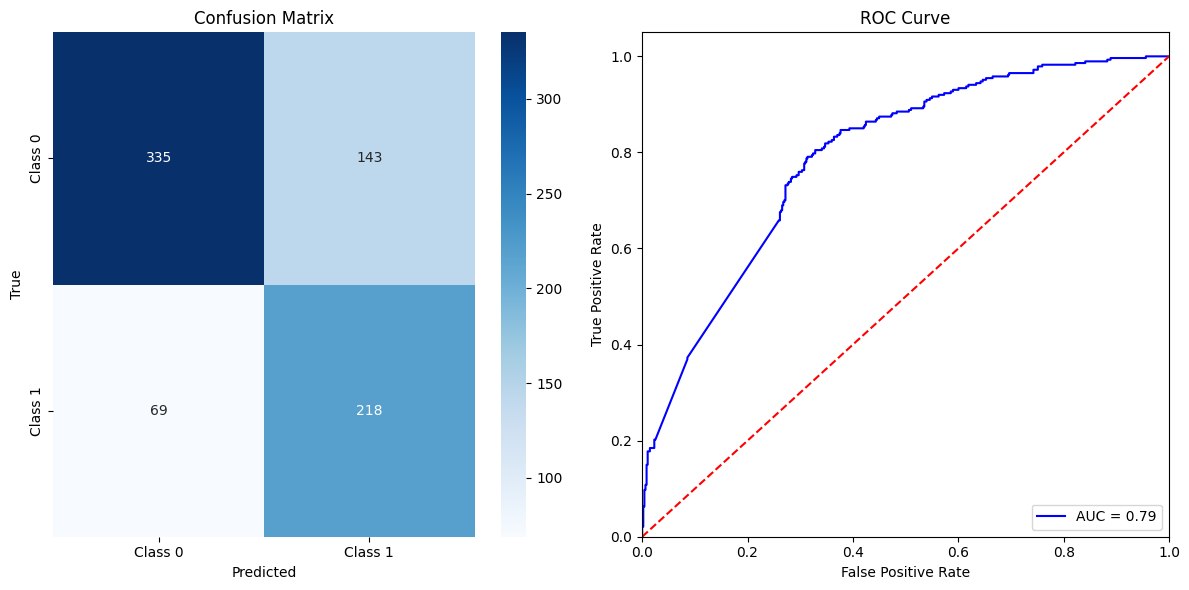

Accuracy of the simple CNN on the test images: 72.29%
Average loss on the test images: 0.5427
Sensitivity (Recall): 0.76
Specificity: 0.70
AUC: 0.79


In [32]:
import torch
import torch.nn as nn
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the model
classifier_model = SimpleCNN(num_classes=2).to(device)  # Initialize your classifier model
model_state_dict = torch.load('simple_cnn_final.pt', weights_only=False)
classifier_model.load_state_dict(model_state_dict)

# Set the model to evaluation mode
classifier_model.eval()

# Define criterion (loss function)
criterion = nn.CrossEntropyLoss()

# Test the model
correct = 0
total = 0
total_loss = 0.0
all_labels = []
all_preds = []
all_probs = []

with torch.no_grad():
    for inputs, labels in test_loader:
        # Send inputs and labels to the device (GPU if available)
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        output = classifier_model(inputs)
        loss = criterion(output, labels)
        
        total_loss += loss.item()
        
        # Get predictions and probabilities
        _, predicted = torch.max(output, 1)
        probs = torch.softmax(output, dim=1)[:, 1]  # Probability for the positive class
        
        # Update counts
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Store predictions, labels, and probabilities for further metrics
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

# Calculate accuracy and average loss
accuracy = 100 * correct / total
average_loss = total_loss / len(test_loader)

# Calculate confusion matrix and derived metrics
conf_matrix = confusion_matrix(all_labels, all_preds)
TN, FP, FN, TP = conf_matrix.ravel()
sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0  # Sensitivity / Recall
specificity = TN / (TN + FP) if (TN + FP) > 0 else 0  # Specificity

# Calculate AUC and plot ROC curve
auc_score = roc_auc_score(all_labels, all_probs)
fpr, tpr, _ = roc_curve(all_labels, all_probs)

# Plot confusion matrix
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Confusion matrix plot
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", ax=ax[0],
            xticklabels=[f'Class {i}' for i in range(num_classes)],
            yticklabels=[f'Class {i}' for i in range(num_classes)])
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('True')
ax[0].set_title('Confusion Matrix')

# ROC curve plot
ax[1].plot(fpr, tpr, color='blue', label=f'AUC = {auc_score:.2f}')
ax[1].plot([0, 1], [0, 1], 'r--')
ax[1].set_xlim([0.0, 1.0])
ax[1].set_ylim([0.0, 1.05])
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate')
ax[1].set_title('ROC Curve')
ax[1].legend(loc="lower right")

plt.tight_layout()
plt.show()

# Print metrics
print(f'Accuracy of the simple CNN on the test images: {accuracy:.2f}%')
print(f'Average loss on the test images: {average_loss:.4f}')
print(f'Sensitivity (Recall): {sensitivity:.2f}')
print(f'Specificity: {specificity:.2f}')
print(f'AUC: {auc_score:.2f}')

# CNN-LSTM

### Using pretrained weights

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNNLSTMOnAutoencoder(nn.Module):
    def __init__(self, autoencoder, hidden_size=128, num_classes=2):
        super(CNNLSTMOnAutoencoder, self).__init__()
        
        # Use the encoder from the pre-trained autoencoder
        self.encoder = autoencoder.encoder
        
        # Convolutional layers with batch normalization
        self.conv1 = nn.Conv3d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm3d(512)
        
        self.conv2 = nn.Conv3d(in_channels=512, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm3d(256)
        
        self.conv3 = nn.Conv3d(in_channels=256, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm3d(128)
        
        # Adaptive max pooling layer
        self.pool = nn.AdaptiveMaxPool3d(output_size=(8, 8, 5))
        
        # LSTM and fully connected layer placeholders (initialized in forward pass)
        self.lstm = None
        self.fc = None

    def forward(self, x):
        batch_size = x.size(0)

        # Pass through the encoder
        x = self.encoder(x)
        
        # Convolutional layers with batch normalization and pooling
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        
        # Get shape after convolutions
        batch_size, channels, new_height, new_width, new_depth = x.shape
        lstm_input_size = channels * new_height * new_width
        
        # Reshape for LSTM input (sequence length is new_depth)
        x = x.view(batch_size, new_depth, lstm_input_size)

        # Initialize LSTM and FC layers if not yet initialized
        if self.lstm is None:
            self.lstm = nn.LSTM(input_size=lstm_input_size, hidden_size=128, batch_first=True).to(x.device)
            self.fc = nn.Linear(in_features=128, out_features=2).to(x.device)

        # Pass through LSTM and fully connected layer
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])  # Take the output from the last LSTM step
        
        return out

In [ ]:
# Load trained autoencoder
trained_autoencoder = CNN_Autoencoder().to(device)
trained_autoencoder.load_state_dict(torch.load(save_path, weights_only=True))
trained_autoencoder.eval() # Set the model to evaluation mode

# Model with pretrained weights
cnn_lstm_with_ae = CNNLSTMOnAutoencoder(trained_autoencoder, hidden_size=128, num_classes=2).to(device)

# Optionally, freeze the encoder layers, Frozen= false, Unfrozen= true
for param in cnn_lstm_with_ae.encoder.parameters():
    param.requires_grad = True

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.SGD(cnn_lstm_with_ae.parameters(), lr=0.001)

In [ ]:
# Training loop

num_epochs = 100
best_val_loss = float('inf')

for epoch in range(num_epochs):
    # Training phase
    cnn_lstm_with_ae.train()
    total_loss = 0.0
    all_labels = []
    all_preds = []

    for batch_idx, (inputs, labels) in enumerate(train_loader):
        # Send inputs and labels to the device (GPU if available)
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        output = cnn_lstm_with_ae(inputs)

        loss = criterion(output, labels)

        # Backward pass
        loss.backward()

        # Update model parameters
        optimizer.step()

        # Accumulate the loss
        total_loss += loss.item()

        # Store predictions and labels for accuracy calculation
        _, preds = torch.max(output, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

    # Calculate training accuracy and average loss for the epoch
    train_accuracy = accuracy_score(all_labels, all_preds)
    avg_train_loss = total_loss / len(train_loader)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')

    # Validation phase
    cnn_lstm_with_ae.eval()
    val_loss = 0.0
    val_labels = []
    val_preds = []

    with torch.no_grad():
        for val_inputs, val_labels_batch in val_loader:
            val_inputs = val_inputs.to(device)
            val_labels_batch = val_labels_batch.to(device)

            # Forward pass for validation data
            val_outputs = cnn_lstm_with_ae(val_inputs)
            loss = criterion(val_outputs, val_labels_batch)
            val_loss += loss.item()

            # Store predictions and labels for accuracy calculation
            _, val_preds_batch = torch.max(val_outputs, 1)
            val_labels.extend(val_labels_batch.cpu().numpy())
            val_preds.extend(val_preds_batch.cpu().numpy())

    # Calculate validation accuracy and average loss
    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = accuracy_score(val_labels, val_preds)

    print(f'Epoch [{epoch+1}/{num_epochs}], Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

    # Save the model if validation loss improves
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(cnn_lstm_with_ae.state_dict(), 'best_cnnlstm_with_ae.pt')
        print(f'Model saved at epoch {epoch+1} with validation loss: {avg_val_loss:.4f}')

    # Save the model after each epoch
    torch.save(cnn_lstm_with_ae.state_dict(), f'cnnlstm_with_ae_epoch{epoch+1}.pt')

# Save the final trained model
torch.save(cnn_lstm_with_ae.state_dict(), 'cnnlstm_with_ae_final.pt')


In [ ]:
# Testing loop

# Load trained autoencoder
trained_autoencoder = CNN_Autoencoder().to(device)
trained_autoencoder.load_state_dict(torch.load(save_path, weights_only=True))
trained_autoencoder.eval() # Set the model to evaluation mode

# Load the model
classifier_model = CNNLSTMOnAutoencoder(trained_autoencoder, hidden_size=128, num_classes=2).to(device)  # Initialize your classifier model
model_state_dict = torch.load('cnnlstm_with_ae_final.pt', weights_only=False)
classifier_model.load_state_dict(model_state_dict)

# Set the model to evaluation mode
classifier_model.eval()

# Define criterion (loss function)
criterion = nn.CrossEntropyLoss()

# Test the model
correct = 0
total = 0
total_loss = 0.0
all_labels = []
all_preds = []

with torch.no_grad():
    for inputs, labels in test_loader:
        # Send inputs and labels to the device (GPU if available)
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        output = simple_cnn_model(inputs)
        # print(outputs.shape)

        loss = criterion(output, labels)

        total_loss += loss.item()
        _, predicted = torch.max(output, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Store predictions and labels for confusion matrix
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

# Calculate accuracy and average loss
accuracy = 100 * correct / total
average_loss = total_loss / len(test_loader)

# Calculate confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix using seaborn
fig, ax = plt.subplots(figsize=(18, 16))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", ax=ax,
            xticklabels=[f'Class {i}' for i in range(num_classes)],
            yticklabels=[f'Class {i}' for i in range(num_classes)])
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix')

# Print accuracy and average loss
print(f'Accuracy of the CNN-LSTM with autoencoder on the test images: {accuracy:.2f}%')
print(f'Average loss on the test images: {average_loss:.4f}')

### Not using pretrained weights

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNNLSTM(nn.Module):
    def __init__(self, hidden_size=128, num_classes=2):
        super(SimpleCNNLSTM, self).__init__()
        
        # Convolutional layers with batch normalization
        self.conv1 = nn.Conv3d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm3d(64)
        
        self.conv2 = nn.Conv3d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm3d(128)
        
        self.conv3 = nn.Conv3d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm3d(256)
        
        # Adaptive max pooling layer
        self.pool = nn.AdaptiveMaxPool3d(output_size=(8, 8, 5))
        
        # LSTM and fully connected layer placeholders
        self.lstm = None
        self.fc = None

    def forward(self, x):
        batch_size = x.size(0)

        # Convolutional layers with batch normalization and pooling
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        
        # Get the output shape after convolutions
        batch_size, channels, new_height, new_width, new_depth = x.shape
        lstm_input_size = channels * new_height * new_width

        # Reshape for LSTM input (sequence length is new_depth)
        x = x.view(batch_size, new_depth, lstm_input_size)

        # Initialize LSTM and FC layers if not yet initialized
        if self.lstm is None:
            self.lstm = nn.LSTM(input_size=lstm_input_size, hidden_size=128, batch_first=True).to(x.device)
            self.fc = nn.Linear(in_features=128, out_features=2).to(x.device)

        # Pass through LSTM and fully connected layer
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])  # Take the output from the last LSTM step
        
        return out

In [ ]:
# Model without pretrained weights
simple_cnnlstm = SimpleCNNLSTM(hidden_size=128, num_classes=2).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.SGD(simple_cnnlstm.parameters(), lr=0.001)

In [ ]:
# Training loop

num_epochs = 100
best_val_loss = float('inf')

for epoch in range(num_epochs):
    # Training phase
    simple_cnnlstm.train()
    total_loss = 0.0
    all_labels = []
    all_preds = []

    for batch_idx, (inputs, labels) in enumerate(train_loader):
        # Send inputs and labels to the device (GPU if available)
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        output = simple_cnnlstm(inputs)

        loss = criterion(output, labels)

        # Backward pass
        loss.backward()

        # Update model parameters
        optimizer.step()

        # Accumulate the loss
        total_loss += loss.item()

        # Store predictions and labels for accuracy calculation
        _, preds = torch.max(output, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

    # Calculate training accuracy and average loss for the epoch
    train_accuracy = accuracy_score(all_labels, all_preds)
    avg_train_loss = total_loss / len(train_loader)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')

    # Validation phase
    simple_cnnlstm.eval()
    val_loss = 0.0
    val_labels = []
    val_preds = []

    with torch.no_grad():
        for val_inputs, val_labels_batch in val_loader:
            val_inputs = val_inputs.to(device)
            val_labels_batch = val_labels_batch.to(device)

            # Forward pass for validation data
            val_outputs = simple_cnnlstm(val_inputs)
            loss = criterion(val_outputs, val_labels_batch)
            val_loss += loss.item()

            # Store predictions and labels for accuracy calculation
            _, val_preds_batch = torch.max(val_outputs, 1)
            val_labels.extend(val_labels_batch.cpu().numpy())
            val_preds.extend(val_preds_batch.cpu().numpy())

    # Calculate validation accuracy and average loss
    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = accuracy_score(val_labels, val_preds)

    print(f'Epoch [{epoch+1}/{num_epochs}], Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

    # Save the model if validation loss improves
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(simple_cnnlstm.state_dict(), 'best_simple_cnnlstm.pt')
        print(f'Model saved at epoch {epoch+1} with validation loss: {avg_val_loss:.4f}')

    # Save the model after each epoch
    torch.save(simple_cnnlstm.state_dict(), f'simple_cnnlstm_epoch{epoch+1}.pt')

# Save the final trained model
torch.save(simple_cnnlstm.state_dict(), 'simple_cnnlstm_final.pt')

In [ ]:
# Testing loop

# Load the model
classifier_model = SimpleCNNLSTM(hidden_size=128, num_classes=2).to(device)  # Initialize your classifier model
model_state_dict = torch.load('simple_cnnlstm_final.pt', weights_only=False)
classifier_model.load_state_dict(model_state_dict)

# Set the model to evaluation mode
classifier_model.eval()

# Define criterion (loss function)
criterion = nn.CrossEntropyLoss()

# Test the model
correct = 0
total = 0
total_loss = 0.0
all_labels = []
all_preds = []

with torch.no_grad():
    for inputs, labels in test_loader:
        # Send inputs and labels to the device (GPU if available)
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        output = simple_cnn_model(inputs)
        # print(outputs.shape)

        loss = criterion(output, labels)

        total_loss += loss.item()
        _, predicted = torch.max(output, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Store predictions and labels for confusion matrix
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

# Calculate accuracy and average loss
accuracy = 100 * correct / total
average_loss = total_loss / len(test_loader)

# Calculate confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix using seaborn
fig, ax = plt.subplots(figsize=(18, 16))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", ax=ax,
            xticklabels=[f'Class {i}' for i in range(num_classes)],
            yticklabels=[f'Class {i}' for i in range(num_classes)])
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix')

# Print accuracy and average loss
print(f'Accuracy of the simple CNN-LSTM on the test images: {accuracy:.2f}%')
print(f'Average loss on the test images: {average_loss:.4f}')